In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from keras.layers import UpSampling2D
from tensorflow.keras.layers import concatenate
import keras_tuner as kt

import os
import glob
import datetime as dt
import numpy as np
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def load_data(image_path, image_size = (224, 224), batch_size = 32):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        image_path, labels='inferred',
        validation_split=0.3,
        label_mode='categorical', # 'int'
        subset="training",
        image_size=image_size,
        batch_size=batch_size,
        seed=42)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        image_path, labels='inferred',
        validation_split=0.3,
        label_mode='categorical', # 'int'
        subset="validation",
        image_size=image_size,
        batch_size=batch_size,
        seed=42)
    return train_ds, val_ds

In [3]:
train_ds, val_ds = load_data(image_path = "W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image", image_size = (224, 224), batch_size = 32)

Found 2000 files belonging to 10 classes.
Using 1400 files for training.
Found 2000 files belonging to 10 classes.
Using 600 files for validation.


In [4]:
# train_ds_256, val_ds_256 = load_data(image_path = "W:\\AAAANot_in_WD\\4042\\proj\\FMD\\image", image_size = (256, 256), batch_size = 32)

Found 2000 files belonging to 10 classes.
Using 1400 files for training.
Found 2000 files belonging to 10 classes.
Using 600 files for validation.


In [5]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

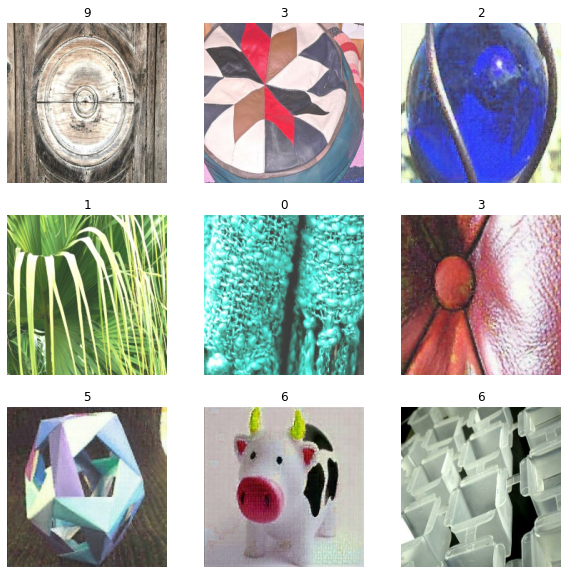

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(np.argmax(labels[i])) # labels.numpy()[i]
        plt.axis("off")

In [7]:
# traditional augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)



In [9]:
tf.__version__

'2.10.0'

In [10]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

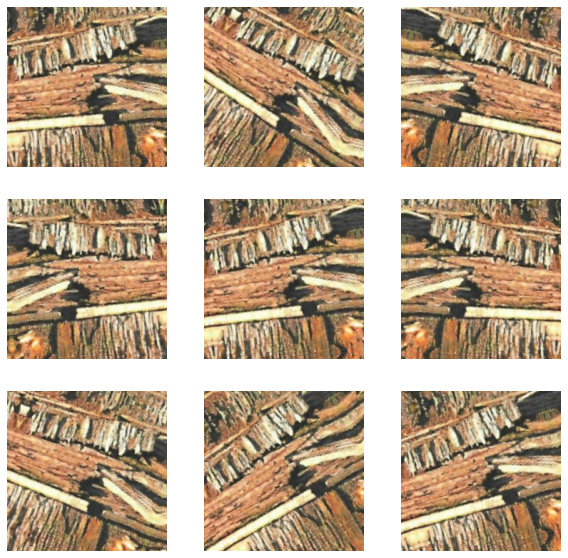

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
# the warnings are due to some bug in tf 2.9.0 and 2.10.0, using 2.8.* or older should be okay

In [12]:
image_size = (224, 224)
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [31]:
def make_model_resnet_pretrained(image_size, num_classes=10):
    input_shape=image_size + (3,)
    resnet_pretrained = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', classes=10)
    resnet_pretrained.trainable = False
    
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x) # normalization
    
    x = resnet_pretrained(x)
    
    x = layers.Dropout(0.2)(x) # 7 7 2048
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # 2048
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes    
    
    outputs = layers.Dense(num_classes, activation=activation)(x) # 10
    return keras.Model(inputs, outputs)

In [33]:
resnet = make_model_resnet_pretrained(image_size=(224, 224), num_classes=10)
resnet.compile(
            optimizer=tf.keras.optimizers.Adam(0.01),
            loss="categorical_crossentropy",
            metrics = ["accuracy"])
keras.utils.plot_model(resnet, show_shapes=True)
resnet.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
# this cell was run using google colab
early_stop = True
# save the model at the end of each epoch so that we can retrieve the model of the best epoch
callbacks = [keras.callbacks.ModelCheckpoint(
                filepath="./saved_model_resnet_pretrained/{epoch}",
                monitor = 'val_acc',
                save_best_only = False,
                save_weights_only = False,
                mode = 'max',
                save_freq='epoch')]

if early_stop:
    callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5))

resnet_hist = resnet.fit(train_ds, validation_data=val_ds, epochs = 50, callbacks = callbacks)

In [36]:
# resnet model from scratch
def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    return x

def non_res_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

def make_model_resnet(input_shape=image_size + (3,), num_classes=10, res_net=True):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x) # normalization
    
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    
    num_blocks = 50
    if res_net:
        for i in range(num_blocks):
            x = res_net_block(x, 64, 3)
    else:
        for i in range(num_blocks):
            x = non_res_block(x, 64, 3)
        
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model



In [37]:
def make_model(input_shape=image_size + (3,), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x) # normalization
    # 224 224 3
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) # 112 112 32
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x) # 56 56 64
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x) # 28 28 128
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual, 28 28 128

    for size in [128, 64, 32, 32]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x) # 28 28 128, 14 14 64, 7 7 32, 4 4 32
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x) # 28 28 128, 14 14 64, 7 7 32, 4 4 32
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # 14 14 128, 7 7 64, 4 4 32, 2 2 32

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation) # 14 14 128, 7 7 64, 4 4 32, 2 2 32
        x = layers.add([x, residual])  # Add back residual, 14 14 128, 7 7 64, 4 4 32, 2 2 32
        previous_block_activation = x  # Set aside next residual, 14 14 128, 7 7 64, 4 4 32, 2 2 32

    x = layers.SeparableConv2D(16, 3, padding="same")(x) # 2 2 16
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x) # 16
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x) # 10
    return keras.Model(inputs, outputs)


In [44]:
def make_model2(input_shape=image_size + (3,), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x) # normalization
    # 224 224 3
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) # 112 112 32
    x = layers.BatchNormalization()(x)
    
    previous_block_activation = x  # Set aside residual, 112 112 32

    for size in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x) # 112 112 64, 56 56 128, 28 28 256
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x) # 112 112 64, 56 56 128, 28 28 256
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # 56 56 64, 28 28 128, 14 14 256

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation) # 56 56 64, 28 28 128, 14 14 256
        x = layers.add([x, residual])  # Add back residual, 56 56 64, 28 28 128, 14 14 256
        previous_block_activation = x  # Set aside next residual, 56 56 64, 28 28 128, 14 14 256

    x = layers.SeparableConv2D(16, 3, padding="same")(x) # 14 14 16
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x) # 16
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x) # 10
    return keras.Model(inputs, outputs)


In [38]:
model = make_model()
model.compile(
            optimizer=tf.keras.optimizers.Adam(0.01),
            loss="categorical_crossentropy",
            metrics = ["accuracy"])
keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_23[0][0]']               
                                                                                                  
 rescaling_11 (Rescaling)       (None, 224, 224, 3)  0           ['sequential[11][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['rescaling_11[0][0]']    

                                                                                                  
 separable_conv2d_4 (SeparableC  (None, 7, 7, 32)    2656        ['activation_6[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 7, 7, 32)    128         ['separable_conv2d_4[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 7, 7, 32)     0           ['batch_normalization_7[0][0]']  
                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 7, 7, 32)    1344        ['activation_7[0][0]']           
 onv2D)   

In [43]:
early_stop = True
# save the model at the end of each epoch so that we can retrieve the model of the best epoch
callbacks = [keras.callbacks.ModelCheckpoint(
                filepath="./saved_model_cnn/{epoch}",
                monitor = 'val_acc',
                save_best_only = False,
                save_weights_only = False,
                mode = 'max',
                save_freq='epoch')]

if early_stop:
    callbacks.append(keras.callbacks.EarlyStopping(monitor='val_acc', patience = 10))

history = model.fit(train_ds, validation_data=val_ds, epochs = 50, callbacks = callbacks)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.0239 - accuracy: 0.2757

44/44 [==============================] - 79s 2s/step - loss: 2.0239 - accuracy: 0.2757 - val_loss: 2.7020 - val_accuracy: 0.1850
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 1.9894 - accuracy: 0.2771

44/44 [==============================] - 84s 2s/step - loss: 1.9894 - accuracy: 0.2771 - val_loss: 2.2169 - val_accuracy: 0.2150
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 1.9936 - accuracy: 0.2686

44/44 [==============================] - 85s 2s/step - loss: 1.9936 - accuracy: 0.2686 - val_loss: 2.2247 - val_accuracy: 0.2333
Epoch 4/50
44/44 [==============================] - ETA: 0s - loss: 1.9773 - accuracy: 0.2650

44/44 [==============================] - 83s 2s/step - loss: 1.9773 - accuracy: 0.2650 - val_loss: 2.2981 - val_accuracy: 0.2233
Epoch 5/50
44/44 [==============================] - ETA: 0s - loss: 1.9861 - accuracy: 0.2750

44/44 [==============================] - 85s 2s/step - loss: 1.9861 - accuracy: 0.2750 - val_loss: 2.3263 - val_accuracy: 0.1817
Epoch 6/50
44/44 [==============================] - ETA: 0s - loss: 1.9815 - accuracy: 0.2786

44/44 [==============================] - 89s 2s/step - loss: 1.9815 - accuracy: 0.2786 - val_loss: 2.3050 - val_accuracy: 0.2317
Epoch 7/50
44/44 [==============================] - ETA: 0s - loss: 1.9747 - accuracy: 0.2843

44/44 [==============================] - 88s 2s/step - loss: 1.9747 - accuracy: 0.2843 - val_loss: 2.9582 - val_accuracy: 0.1850
Epoch 8/50
44/44 [==============================] - ETA: 0s - loss: 1.9414 - accuracy: 0.2993

44/44 [==============================] - 89s 2s/step - loss: 1.9414 - accuracy: 0.2993 - val_loss: 2.4693 - val_accuracy: 0.1900
Epoch 9/50
44/44 [==============================] - ETA: 0s - loss: 1.9359 - accuracy: 0.3057

44/44 [==============================] - 83s 2s/step - loss: 1.9359 - accuracy: 0.3057 - val_loss: 2.6185 - val_accuracy: 0.1817
Epoch 10/50
44/44 [==============================] - ETA: 0s - loss: 1.9257 - accuracy: 0.3014

44/44 [==============================] - 83s 2s/step - loss: 1.9257 - accuracy: 0.3014 - val_loss: 2.4165 - val_accuracy: 0.2067
Epoch 11/50
44/44 [==============================] - ETA: 0s - loss: 1.9221 - accuracy: 0.3014

44/44 [==============================] - 86s 2s/step - loss: 1.9221 - accuracy: 0.3014 - val_loss: 2.7595 - val_accuracy: 0.2633
Epoch 12/50
44/44 [==============================] - ETA: 0s - loss: 1.9360 - accuracy: 0.2964

44/44 [==============================] - 81s 2s/step - loss: 1.9360 - accuracy: 0.2964 - val_loss: 2.1137 - val_accuracy: 0.2350
Epoch 13/50
44/44 [==============================] - ETA: 0s - loss: 1.9346 - accuracy: 0.2900

44/44 [==============================] - 84s 2s/step - loss: 1.9346 - accuracy: 0.2900 - val_loss: 2.0691 - val_accuracy: 0.2733
Epoch 14/50
44/44 [==============================] - ETA: 0s - loss: 1.8713 - accuracy: 0.3336

44/44 [==============================] - 82s 2s/step - loss: 1.8713 - accuracy: 0.3336 - val_loss: 1.9590 - val_accuracy: 0.2750
Epoch 15/50
44/44 [==============================] - ETA: 0s - loss: 1.8817 - accuracy: 0.3143

44/44 [==============================] - 84s 2s/step - loss: 1.8817 - accuracy: 0.3143 - val_loss: 2.2887 - val_accuracy: 0.2550
Epoch 16/50
44/44 [==============================] - ETA: 0s - loss: 1.9088 - accuracy: 0.2971

44/44 [==============================] - 83s 2s/step - loss: 1.9088 - accuracy: 0.2971 - val_loss: 2.4222 - val_accuracy: 0.2050
Epoch 17/50
44/44 [==============================] - ETA: 0s - loss: 1.8494 - accuracy: 0.3150

44/44 [==============================] - 85s 2s/step - loss: 1.8494 - accuracy: 0.3150 - val_loss: 1.9599 - val_accuracy: 0.3117
Epoch 18/50
44/44 [==============================] - ETA: 0s - loss: 1.8925 - accuracy: 0.3157

44/44 [==============================] - 120s 3s/step - loss: 1.8925 - accuracy: 0.3157 - val_loss: 2.2340 - val_accuracy: 0.2550
Epoch 19/50
44/44 [==============================] - ETA: 0s - loss: 1.8448 - accuracy: 0.3321

44/44 [==============================] - 80s 2s/step - loss: 1.8448 - accuracy: 0.3321 - val_loss: 2.0575 - val_accuracy: 0.2650
Epoch 20/50
44/44 [==============================] - ETA: 0s - loss: 1.8800 - accuracy: 0.3121

44/44 [==============================] - 79s 2s/step - loss: 1.8800 - accuracy: 0.3121 - val_loss: 2.2943 - val_accuracy: 0.2450
Epoch 21/50
44/44 [==============================] - ETA: 0s - loss: 1.8553 - accuracy: 0.3379

44/44 [==============================] - 83s 2s/step - loss: 1.8553 - accuracy: 0.3379 - val_loss: 2.8003 - val_accuracy: 0.2367
Epoch 22/50
44/44 [==============================] - ETA: 0s - loss: 1.8382 - accuracy: 0.3350

44/44 [==============================] - 89s 2s/step - loss: 1.8382 - accuracy: 0.3350 - val_loss: 1.9613 - val_accuracy: 0.2917
Epoch 23/50
44/44 [==============================] - ETA: 0s - loss: 1.8709 - accuracy: 0.3271

44/44 [==============================] - 85s 2s/step - loss: 1.8709 - accuracy: 0.3271 - val_loss: 2.4879 - val_accuracy: 0.2017
Epoch 24/50
44/44 [==============================] - ETA: 0s - loss: 1.8150 - accuracy: 0.3279

44/44 [==============================] - 85s 2s/step - loss: 1.8150 - accuracy: 0.3279 - val_loss: 2.1211 - val_accuracy: 0.2417
Epoch 25/50
44/44 [==============================] - ETA: 0s - loss: 1.8124 - accuracy: 0.3436

44/44 [==============================] - 86s 2s/step - loss: 1.8124 - accuracy: 0.3436 - val_loss: 2.0397 - val_accuracy: 0.2917
Epoch 26/50
44/44 [==============================] - ETA: 0s - loss: 1.7780 - accuracy: 0.3464

44/44 [==============================] - 85s 2s/step - loss: 1.7780 - accuracy: 0.3464 - val_loss: 2.1555 - val_accuracy: 0.2267
Epoch 27/50
44/44 [==============================] - ETA: 0s - loss: 1.8180 - accuracy: 0.3579

44/44 [==============================] - 84s 2s/step - loss: 1.8180 - accuracy: 0.3579 - val_loss: 2.2826 - val_accuracy: 0.2750
Epoch 28/50
44/44 [==============================] - ETA: 0s - loss: 1.7741 - accuracy: 0.3571

44/44 [==============================] - 88s 2s/step - loss: 1.7741 - accuracy: 0.3571 - val_loss: 2.1888 - val_accuracy: 0.2700
Epoch 29/50
44/44 [==============================] - ETA: 0s - loss: 1.7903 - accuracy: 0.3514

44/44 [==============================] - 94s 2s/step - loss: 1.7903 - accuracy: 0.3514 - val_loss: 2.0401 - val_accuracy: 0.2883
Epoch 30/50
44/44 [==============================] - ETA: 0s - loss: 1.7889 - accuracy: 0.3443

44/44 [==============================] - 90s 2s/step - loss: 1.7889 - accuracy: 0.3443 - val_loss: 1.8569 - val_accuracy: 0.3450
Epoch 31/50
44/44 [==============================] - ETA: 0s - loss: 1.7514 - accuracy: 0.3450

44/44 [==============================] - 87s 2s/step - loss: 1.7514 - accuracy: 0.3450 - val_loss: 2.0147 - val_accuracy: 0.3283
Epoch 32/50
44/44 [==============================] - ETA: 0s - loss: 1.7323 - accuracy: 0.3757

44/44 [==============================] - 87s 2s/step - loss: 1.7323 - accuracy: 0.3757 - val_loss: 2.5572 - val_accuracy: 0.2217
Epoch 33/50
44/44 [==============================] - ETA: 0s - loss: 1.7448 - accuracy: 0.3779

44/44 [==============================] - 94s 2s/step - loss: 1.7448 - accuracy: 0.3779 - val_loss: 2.4182 - val_accuracy: 0.2733
Epoch 34/50
44/44 [==============================] - ETA: 0s - loss: 1.7293 - accuracy: 0.3843

44/44 [==============================] - 84s 2s/step - loss: 1.7293 - accuracy: 0.3843 - val_loss: 1.8806 - val_accuracy: 0.3317
Epoch 35/50
44/44 [==============================] - ETA: 0s - loss: 1.6967 - accuracy: 0.3779

44/44 [==============================] - 83s 2s/step - loss: 1.6967 - accuracy: 0.3779 - val_loss: 1.8880 - val_accuracy: 0.3667
Epoch 36/50
44/44 [==============================] - ETA: 0s - loss: 1.6902 - accuracy: 0.3914

44/44 [==============================] - 82s 2s/step - loss: 1.6902 - accuracy: 0.3914 - val_loss: 2.1779 - val_accuracy: 0.2267
Epoch 37/50
44/44 [==============================] - ETA: 0s - loss: 1.6730 - accuracy: 0.3843

44/44 [==============================] - 87s 2s/step - loss: 1.6730 - accuracy: 0.3843 - val_loss: 2.3151 - val_accuracy: 0.3150
Epoch 38/50
44/44 [==============================] - ETA: 0s - loss: 1.6786 - accuracy: 0.4007

44/44 [==============================] - 81s 2s/step - loss: 1.6786 - accuracy: 0.4007 - val_loss: 1.9420 - val_accuracy: 0.3383
Epoch 39/50
44/44 [==============================] - ETA: 0s - loss: 1.6535 - accuracy: 0.4093

44/44 [==============================] - 84s 2s/step - loss: 1.6535 - accuracy: 0.4093 - val_loss: 1.9425 - val_accuracy: 0.3550
Epoch 40/50
44/44 [==============================] - ETA: 0s - loss: 1.6455 - accuracy: 0.4014

44/44 [==============================] - 82s 2s/step - loss: 1.6455 - accuracy: 0.4014 - val_loss: 1.9379 - val_accuracy: 0.3383
Epoch 41/50
44/44 [==============================] - ETA: 0s - loss: 1.6226 - accuracy: 0.4071

44/44 [==============================] - 82s 2s/step - loss: 1.6226 - accuracy: 0.4071 - val_loss: 1.8530 - val_accuracy: 0.3217
Epoch 42/50
44/44 [==============================] - ETA: 0s - loss: 1.6256 - accuracy: 0.4107

44/44 [==============================] - 84s 2s/step - loss: 1.6256 - accuracy: 0.4107 - val_loss: 1.9415 - val_accuracy: 0.3533
Epoch 43/50
44/44 [==============================] - ETA: 0s - loss: 1.5610 - accuracy: 0.4343

44/44 [==============================] - 80s 2s/step - loss: 1.5610 - accuracy: 0.4343 - val_loss: 1.9166 - val_accuracy: 0.3467
Epoch 44/50
44/44 [==============================] - ETA: 0s - loss: 1.5538 - accuracy: 0.4543

44/44 [==============================] - 81s 2s/step - loss: 1.5538 - accuracy: 0.4543 - val_loss: 1.7294 - val_accuracy: 0.3667
Epoch 45/50
44/44 [==============================] - ETA: 0s - loss: 1.6295 - accuracy: 0.4136

44/44 [==============================] - 85s 2s/step - loss: 1.6295 - accuracy: 0.4136 - val_loss: 2.4926 - val_accuracy: 0.2700
Epoch 46/50
44/44 [==============================] - ETA: 0s - loss: 1.5651 - accuracy: 0.4300

44/44 [==============================] - 106s 2s/step - loss: 1.5651 - accuracy: 0.4300 - val_loss: 2.3305 - val_accuracy: 0.2733
Epoch 47/50
44/44 [==============================] - ETA: 0s - loss: 1.5103 - accuracy: 0.4586

44/44 [==============================] - 94s 2s/step - loss: 1.5103 - accuracy: 0.4586 - val_loss: 1.9257 - val_accuracy: 0.3383
Epoch 48/50
44/44 [==============================] - ETA: 0s - loss: 1.5476 - accuracy: 0.4407

44/44 [==============================] - 97s 2s/step - loss: 1.5476 - accuracy: 0.4407 - val_loss: 1.8262 - val_accuracy: 0.3683
Epoch 49/50
44/44 [==============================] - ETA: 0s - loss: 1.5529 - accuracy: 0.4286

44/44 [==============================] - 84s 2s/step - loss: 1.5529 - accuracy: 0.4286 - val_loss: 2.1813 - val_accuracy: 0.3267
Epoch 50/50
44/44 [==============================] - ETA: 0s - loss: 1.4594 - accuracy: 0.4721

44/44 [==============================] - 83s 2s/step - loss: 1.4594 - accuracy: 0.4721 - val_loss: 2.3131 - val_accuracy: 0.3400


In [45]:
# model architecture 2
model2 = make_model2()
model2.compile(
            optimizer=tf.keras.optimizers.Adam(0.01),
            loss="categorical_crossentropy",
            metrics = ["accuracy"])
keras.utils.plot_model(model2, show_shapes=True)
model2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_24[0][0]']               
                                                                                                  
 rescaling_12 (Rescaling)       (None, 224, 224, 3)  0           ['sequential[12][0]']            
                                                                                                  
 conv2d_7 (Conv2D)              (None, 112, 112, 32  896         ['rescaling_12[0][0]']    

                                                                                                  
 add_6 (Add)                    (None, 14, 14, 256)  0           ['max_pooling2d_6[0][0]',        
                                                                  'conv2d_10[0][0]']              
                                                                                                  
 separable_conv2d_15 (Separable  (None, 14, 14, 16)  6416        ['add_6[0][0]']                  
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 14, 14, 16)  64          ['separable_conv2d_15[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 activatio

In [66]:
# model architecture 2
early_stop = True
# save the model at the end of each epoch so that we can retrieve the model of the best epoch
callbacks = [keras.callbacks.ModelCheckpoint(
                filepath="./saved_model_cnn2/{epoch}",
                monitor = 'val_acc',
                save_best_only = False,
                save_weights_only = False,
                mode = 'max',
                save_freq='epoch')]

if early_stop:
    callbacks.append(keras.callbacks.EarlyStopping(monitor='val_acc', patience = 10))

history2 = model2.fit(train_ds, validation_data=val_ds, epochs = 50, callbacks = callbacks)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.2381 - accuracy: 0.1857

44/44 [==============================] - 160s 4s/step - loss: 2.2381 - accuracy: 0.1857 - val_loss: 2.4333 - val_accuracy: 0.1167
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 2.1297 - accuracy: 0.2114

44/44 [==============================] - 195s 4s/step - loss: 2.1297 - accuracy: 0.2114 - val_loss: 2.2760 - val_accuracy: 0.1450
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 2.0963 - accuracy: 0.2257

44/44 [==============================] - 179s 4s/step - loss: 2.0963 - accuracy: 0.2257 - val_loss: 2.3618 - val_accuracy: 0.1333
Epoch 4/50
44/44 [==============================] - ETA: 0s - loss: 2.0603 - accuracy: 0.2414

44/44 [==============================] - 201s 5s/step - loss: 2.0603 - accuracy: 0.2414 - val_loss: 2.2270 - val_accuracy: 0.1717
Epoch 5/50
44/44 [==============================] - ETA: 0s - loss: 2.0542 - accuracy: 0.2571

44/44 [==============================] - 184s 4s/step - loss: 2.0542 - accuracy: 0.2571 - val_loss: 3.2800 - val_accuracy: 0.1417
Epoch 6/50
44/44 [==============================] - ETA: 0s - loss: 2.0484 - accuracy: 0.2571

44/44 [==============================] - 190s 4s/step - loss: 2.0484 - accuracy: 0.2571 - val_loss: 7.4666 - val_accuracy: 0.1567
Epoch 7/50
44/44 [==============================] - ETA: 0s - loss: 2.0391 - accuracy: 0.2707

44/44 [==============================] - 183s 4s/step - loss: 2.0391 - accuracy: 0.2707 - val_loss: 3.3842 - val_accuracy: 0.1267
Epoch 8/50
44/44 [==============================] - ETA: 0s - loss: 1.9626 - accuracy: 0.2779

44/44 [==============================] - 198s 5s/step - loss: 1.9626 - accuracy: 0.2779 - val_loss: 2.5670 - val_accuracy: 0.2550
Epoch 9/50
44/44 [==============================] - ETA: 0s - loss: 1.9954 - accuracy: 0.2850

44/44 [==============================] - 196s 4s/step - loss: 1.9954 - accuracy: 0.2850 - val_loss: 2.5065 - val_accuracy: 0.2250
Epoch 10/50
44/44 [==============================] - ETA: 0s - loss: 1.9936 - accuracy: 0.2736

44/44 [==============================] - 206s 5s/step - loss: 1.9936 - accuracy: 0.2736 - val_loss: 2.3836 - val_accuracy: 0.2283
Epoch 11/50
44/44 [==============================] - ETA: 0s - loss: 1.9749 - accuracy: 0.2829

44/44 [==============================] - 203s 5s/step - loss: 1.9749 - accuracy: 0.2829 - val_loss: 2.8445 - val_accuracy: 0.1983
Epoch 12/50
44/44 [==============================] - ETA: 0s - loss: 1.9570 - accuracy: 0.3000

44/44 [==============================] - 273s 6s/step - loss: 1.9570 - accuracy: 0.3000 - val_loss: 2.3221 - val_accuracy: 0.2583
Epoch 13/50
44/44 [==============================] - ETA: 0s - loss: 1.9213 - accuracy: 0.3036

44/44 [==============================] - 168s 4s/step - loss: 1.9213 - accuracy: 0.3036 - val_loss: 2.6654 - val_accuracy: 0.1933
Epoch 14/50
44/44 [==============================] - ETA: 0s - loss: 1.9193 - accuracy: 0.2914

44/44 [==============================] - 181s 4s/step - loss: 1.9193 - accuracy: 0.2914 - val_loss: 2.0435 - val_accuracy: 0.3150
Epoch 15/50
44/44 [==============================] - ETA: 0s - loss: 1.9152 - accuracy: 0.3050

44/44 [==============================] - 197s 5s/step - loss: 1.9152 - accuracy: 0.3050 - val_loss: 2.5838 - val_accuracy: 0.2550
Epoch 16/50
44/44 [==============================] - ETA: 0s - loss: 1.9050 - accuracy: 0.3100

44/44 [==============================] - 189s 4s/step - loss: 1.9050 - accuracy: 0.3100 - val_loss: 2.2447 - val_accuracy: 0.2350
Epoch 17/50
44/44 [==============================] - ETA: 0s - loss: 1.9072 - accuracy: 0.3236

44/44 [==============================] - 185s 4s/step - loss: 1.9072 - accuracy: 0.3236 - val_loss: 2.3427 - val_accuracy: 0.2500
Epoch 18/50
44/44 [==============================] - ETA: 0s - loss: 1.8981 - accuracy: 0.3121

44/44 [==============================] - 201s 5s/step - loss: 1.8981 - accuracy: 0.3121 - val_loss: 2.5194 - val_accuracy: 0.2483
Epoch 19/50
44/44 [==============================] - ETA: 0s - loss: 1.9054 - accuracy: 0.3179

44/44 [==============================] - 194s 4s/step - loss: 1.9054 - accuracy: 0.3179 - val_loss: 3.1060 - val_accuracy: 0.2267
Epoch 20/50
44/44 [==============================] - ETA: 0s - loss: 1.8767 - accuracy: 0.3400

44/44 [==============================] - 184s 4s/step - loss: 1.8767 - accuracy: 0.3400 - val_loss: 2.0479 - val_accuracy: 0.3083
Epoch 21/50
44/44 [==============================] - ETA: 0s - loss: 1.8436 - accuracy: 0.3293

44/44 [==============================] - 181s 4s/step - loss: 1.8436 - accuracy: 0.3293 - val_loss: 2.3058 - val_accuracy: 0.2133
Epoch 22/50
44/44 [==============================] - ETA: 0s - loss: 1.8780 - accuracy: 0.3229

44/44 [==============================] - 185s 4s/step - loss: 1.8780 - accuracy: 0.3229 - val_loss: 2.6882 - val_accuracy: 0.2117
Epoch 23/50
44/44 [==============================] - ETA: 0s - loss: 1.8315 - accuracy: 0.3464

44/44 [==============================] - 186s 4s/step - loss: 1.8315 - accuracy: 0.3464 - val_loss: 2.1606 - val_accuracy: 0.2683
Epoch 24/50
44/44 [==============================] - ETA: 0s - loss: 1.8327 - accuracy: 0.3371

44/44 [==============================] - 185s 4s/step - loss: 1.8327 - accuracy: 0.3371 - val_loss: 2.3795 - val_accuracy: 0.2550
Epoch 25/50
44/44 [==============================] - ETA: 0s - loss: 1.8454 - accuracy: 0.3386

44/44 [==============================] - 195s 4s/step - loss: 1.8454 - accuracy: 0.3386 - val_loss: 1.8991 - val_accuracy: 0.3483
Epoch 26/50
44/44 [==============================] - ETA: 0s - loss: 1.8006 - accuracy: 0.3557

44/44 [==============================] - 178s 4s/step - loss: 1.8006 - accuracy: 0.3557 - val_loss: 2.0471 - val_accuracy: 0.2650
Epoch 27/50
44/44 [==============================] - ETA: 0s - loss: 1.7858 - accuracy: 0.3621

44/44 [==============================] - 182s 4s/step - loss: 1.7858 - accuracy: 0.3621 - val_loss: 3.3168 - val_accuracy: 0.2350
Epoch 28/50
44/44 [==============================] - ETA: 0s - loss: 1.8271 - accuracy: 0.3314

44/44 [==============================] - 182s 4s/step - loss: 1.8271 - accuracy: 0.3314 - val_loss: 2.0159 - val_accuracy: 0.2567
Epoch 29/50
44/44 [==============================] - ETA: 0s - loss: 1.7701 - accuracy: 0.3614

44/44 [==============================] - 181s 4s/step - loss: 1.7701 - accuracy: 0.3614 - val_loss: 2.6586 - val_accuracy: 0.1933
Epoch 30/50
44/44 [==============================] - ETA: 0s - loss: 1.8391 - accuracy: 0.3400

44/44 [==============================] - 178s 4s/step - loss: 1.8391 - accuracy: 0.3400 - val_loss: 1.9942 - val_accuracy: 0.3067
Epoch 31/50
44/44 [==============================] - ETA: 0s - loss: 1.7756 - accuracy: 0.3600

44/44 [==============================] - 184s 4s/step - loss: 1.7756 - accuracy: 0.3600 - val_loss: 2.2157 - val_accuracy: 0.2733
Epoch 32/50
44/44 [==============================] - ETA: 0s - loss: 1.8023 - accuracy: 0.3493

44/44 [==============================] - 182s 4s/step - loss: 1.8023 - accuracy: 0.3493 - val_loss: 2.1277 - val_accuracy: 0.2850
Epoch 33/50
44/44 [==============================] - ETA: 0s - loss: 1.7584 - accuracy: 0.3779

44/44 [==============================] - 183s 4s/step - loss: 1.7584 - accuracy: 0.3779 - val_loss: 1.9201 - val_accuracy: 0.3150
Epoch 34/50
44/44 [==============================] - ETA: 0s - loss: 1.7619 - accuracy: 0.3679

44/44 [==============================] - 183s 4s/step - loss: 1.7619 - accuracy: 0.3679 - val_loss: 1.9849 - val_accuracy: 0.3167
Epoch 35/50
44/44 [==============================] - ETA: 0s - loss: 1.7793 - accuracy: 0.3636

44/44 [==============================] - 180s 4s/step - loss: 1.7793 - accuracy: 0.3636 - val_loss: 1.9774 - val_accuracy: 0.3200
Epoch 36/50
44/44 [==============================] - ETA: 0s - loss: 1.7696 - accuracy: 0.3779

44/44 [==============================] - 180s 4s/step - loss: 1.7696 - accuracy: 0.3779 - val_loss: 1.9025 - val_accuracy: 0.3017
Epoch 37/50
44/44 [==============================] - ETA: 0s - loss: 1.7757 - accuracy: 0.3629

44/44 [==============================] - 179s 4s/step - loss: 1.7757 - accuracy: 0.3629 - val_loss: 2.0165 - val_accuracy: 0.3017
Epoch 38/50
44/44 [==============================] - ETA: 0s - loss: 1.7598 - accuracy: 0.3543

44/44 [==============================] - 177s 4s/step - loss: 1.7598 - accuracy: 0.3543 - val_loss: 2.1912 - val_accuracy: 0.3117
Epoch 39/50
44/44 [==============================] - ETA: 0s - loss: 1.7325 - accuracy: 0.3964

44/44 [==============================] - 182s 4s/step - loss: 1.7325 - accuracy: 0.3964 - val_loss: 2.4792 - val_accuracy: 0.2517
Epoch 40/50
44/44 [==============================] - ETA: 0s - loss: 1.7261 - accuracy: 0.3857

44/44 [==============================] - 189s 4s/step - loss: 1.7261 - accuracy: 0.3857 - val_loss: 2.5040 - val_accuracy: 0.2833
Epoch 41/50
44/44 [==============================] - ETA: 0s - loss: 1.6947 - accuracy: 0.3821

44/44 [==============================] - 181s 4s/step - loss: 1.6947 - accuracy: 0.3821 - val_loss: 2.1552 - val_accuracy: 0.2717
Epoch 42/50
44/44 [==============================] - ETA: 0s - loss: 1.6955 - accuracy: 0.3907

44/44 [==============================] - 178s 4s/step - loss: 1.6955 - accuracy: 0.3907 - val_loss: 2.1663 - val_accuracy: 0.2833
Epoch 43/50
44/44 [==============================] - ETA: 0s - loss: 1.7184 - accuracy: 0.3771

44/44 [==============================] - 182s 4s/step - loss: 1.7184 - accuracy: 0.3771 - val_loss: 1.8948 - val_accuracy: 0.3450
Epoch 44/50
44/44 [==============================] - ETA: 0s - loss: 1.7003 - accuracy: 0.4000

44/44 [==============================] - 188s 4s/step - loss: 1.7003 - accuracy: 0.4000 - val_loss: 1.9658 - val_accuracy: 0.3383
Epoch 45/50
44/44 [==============================] - ETA: 0s - loss: 1.7146 - accuracy: 0.3821

44/44 [==============================] - 191s 4s/step - loss: 1.7146 - accuracy: 0.3821 - val_loss: 1.8947 - val_accuracy: 0.3250
Epoch 46/50
44/44 [==============================] - ETA: 0s - loss: 1.7092 - accuracy: 0.3893

44/44 [==============================] - 195s 4s/step - loss: 1.7092 - accuracy: 0.3893 - val_loss: 1.9473 - val_accuracy: 0.3383
Epoch 47/50
44/44 [==============================] - ETA: 0s - loss: 1.6631 - accuracy: 0.4143

44/44 [==============================] - 195s 4s/step - loss: 1.6631 - accuracy: 0.4143 - val_loss: 2.9223 - val_accuracy: 0.2683
Epoch 48/50
44/44 [==============================] - ETA: 0s - loss: 1.6548 - accuracy: 0.4057

44/44 [==============================] - 190s 4s/step - loss: 1.6548 - accuracy: 0.4057 - val_loss: 2.4951 - val_accuracy: 0.2583
Epoch 49/50
44/44 [==============================] - ETA: 0s - loss: 1.6758 - accuracy: 0.3914

44/44 [==============================] - 198s 5s/step - loss: 1.6758 - accuracy: 0.3914 - val_loss: 2.8662 - val_accuracy: 0.2717
Epoch 50/50
44/44 [==============================] - ETA: 0s - loss: 1.6631 - accuracy: 0.3871

44/44 [==============================] - 190s 4s/step - loss: 1.6631 - accuracy: 0.3871 - val_loss: 2.1112 - val_accuracy: 0.3500


In [40]:
import matplotlib.pyplot as plt
def plot_model_performance(history):
    """This function plots the training and validation accuracy values"""
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
        
    epochs = list(range(1, len(train_acc)+1))
    assert(len(train_acc)==len(train_loss)==len(epochs))
    
    fig, axis = plt.subplots(1,2,figsize=(15,4))
    axis[0].plot(epochs, train_acc, linestyle='-', color='r', label=f'Training accuracy')
    axis[0].plot(epochs, val_acc, linestyle='--', color='b', label=f'Validation accuracy')
    
    axis[1].plot(epochs, train_loss, linestyle='-', color='r', label=f'Training loss')
    axis[1].plot(epochs, val_loss, linestyle='--', color='b', label=f'Validation loss')
        
    axis[0].set_title('Training and Validation accuracy values')
    axis[0].legend()
    axis[0].set_xlabel('No. epoch')
    axis[0].set_ylabel('Accuracy')
    
    axis[1].set_title('Training and Validation Loss')
    axis[1].legend()
    axis[1].set_xlabel('No. epoch')
    axis[1].set_ylabel('Loss')
    
    #fig.savefig('PartB_Question2_performance_with_loss.png')

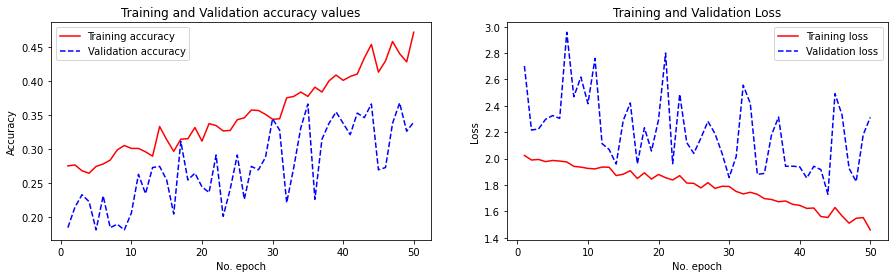

In [46]:
# fit history
plot_model_performance(history)

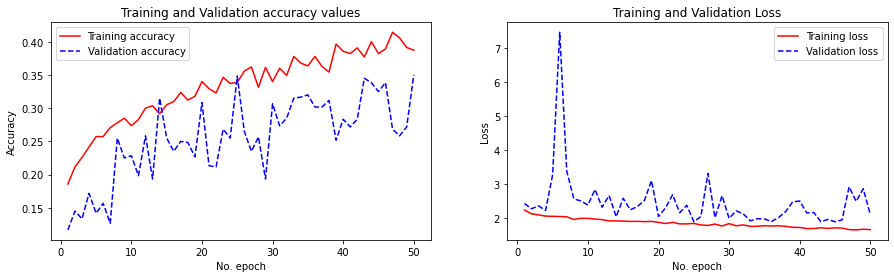

In [67]:
# fit history
plot_model_performance(history2)

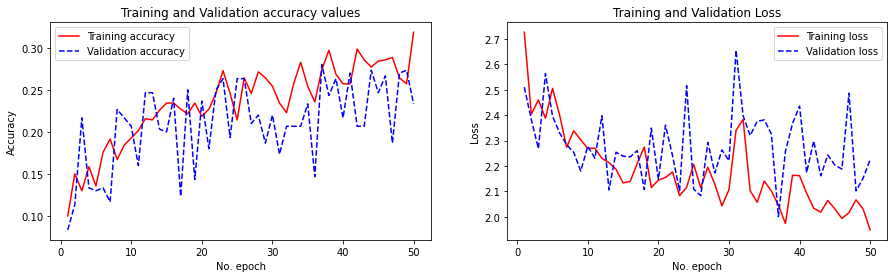

In [23]:
# res_net fit history
# this cell was run using google colab
plot_model_performance(resnet_hist)

In [68]:
def test_image(model, file_name):
    img = keras.utils.load_img("test/"+file_name, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    plt.figure()
    plt.imshow(img_array/255)

    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)

    labels = ['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']
    prediction = labels[np.argmax(predictions)]
    print(f"The material in the image is {prediction}.")

1/1 [==============================] - 0s 30ms/step
The material in the image is leather.


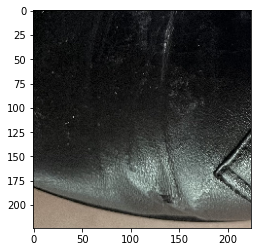

In [62]:
test_image(model, "leather1.jpg")

1/1 [==============================] - 0s 45ms/step
The material in the image is foliage.


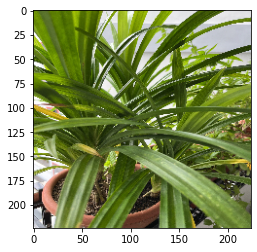

In [70]:
test_image(model2, "foliage1.jpg")

In [64]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory="W:\\AAAANot_in_WD\\4042\\proj\\FMD\\test", 
        labels='inferred',
        label_mode='categorical', # 'int'
        validation_split=None,
        class_names=labels,
        image_size=image_size,
        batch_size=32,
        seed=42)
test_ds = test_ds.prefetch(buffer_size=32)

Found 30 files belonging to 10 classes.


In [65]:
model.evaluate(test_ds)

1/1 [==============================] - 5s 5s/step - loss: 3.2110 - accuracy: 0.2333


[3.2109615802764893, 0.23333333432674408]

In [71]:
model2.evaluate(test_ds)

1/1 [==============================] - 5s 5s/step - loss: 2.7651 - accuracy: 0.2667


[2.7651400566101074, 0.2666666805744171]

In [33]:
# this cell was run using google colab
resnet.evaluate(test_ds)

1/1 [==============================] - 15s 15s/step - loss: 2.5014 - accuracy: 0.1333


[2.5013554096221924, 0.13333334028720856]